<a href="https://colab.research.google.com/github/codeby3/searchable-encryption/blob/main/zilliz/dcpe/zilliz_dcpe_vector_search_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up

In [6]:
!pip install -qU beir sentence-transformers pymilvus datasets pycryptodome

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 24.8 MB/s eta 0:00:00


In [2]:
!pip install --upgrade --quiet torch torchvision --extra-index-url https://download.pytorch.org/whl/cu118

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.9/663.9 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 905.3/905.3 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 111.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 93.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.1/204.1 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [19]:
import os
from beir import util
from beir.datasets.data_loader import GenericDataLoader
from beir.retrieval.evaluation import EvaluateRetrieval
import pandas as pd
from pymilvus import MilvusClient, FieldSchema, DataType, CollectionSchema, Collection
from sentence_transformers import SentenceTransformer
import torch
from google.colab import userdata
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import base64
import time
import numpy as np
import sys
import os

In [7]:
sys.path.append(os.getcwd())
import dcpe

In [15]:
DCPE_KEY = dcpe.DCPEKey.generate_random(scaling_factor=1.2) # Using a scaling factor of 1.2
DCPE_APPROXIMATION_FACTOR = 1.0 # Using an approximation factor of 1.0 for a good tradeoff between sceurity and accuracy

# Load Datasets
We're using 3 datasets from the BEIR datasets - nfcorpus, fiqa and scidocs (https://huggingface.co/datasets/BeIR/beir)

In [8]:
datasets_to_load = ["nfcorpus", "fiqa", "scidocs"]
beir_data_path = "./beir_datasets" # Local directory to store BEIR data
os.makedirs(beir_data_path, exist_ok=True)
loaded_beir_data = {}

In [9]:
for dataset_name in datasets_to_load:
    print(f"\nProcessing dataset: {dataset_name}")

    # Step 3a: Download the dataset
    url = f"https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/{dataset_name}.zip"
    out_dir = os.path.join(beir_data_path, dataset_name)

    if not os.path.exists(out_dir):
        print(f"Downloading {dataset_name} from {url} to {out_dir}...")
        data_path = util.download_and_unzip(url, out_dir)
        print(f"Downloaded {dataset_name} to: {data_path}")
    else:
        print(f"Dataset {dataset_name} already exists at {out_dir}. Skipping download.")
        data_path = out_dir

    # Step 3b: Load the corpus, queries, and qrels
    try:
        corpus, queries, qrels = GenericDataLoader(data_folder=data_path).load(split="test")
        loaded_beir_data[dataset_name] = {
            "corpus": corpus,
            "queries": queries,
            "qrels": qrels
        }
        print(f"Successfully loaded data for {dataset_name}.")
        print(f"  Corpus size: {len(corpus)} documents")
        print(f"  Queries size: {len(queries)} queries")
        print(f"  Qrels size: {len(qrels)} relevance judgments")

        # Print a sample document and query to verify
        if len(corpus) > 0:
            sample_doc_id = list(corpus.keys())[0]
            print(f"  Sample corpus entry ({sample_doc_id}): {corpus[sample_doc_id]['title']} - {corpus[sample_doc_id]['text'][:100]}...")
        if len(queries) > 0:
            sample_query_id = list(queries.keys())[0]
            print(f"  Sample query entry ({sample_query_id}): {queries[sample_query_id][:100]}...")

    except Exception as e:
        print(f"Error loading {dataset_name}: {e}")


Processing dataset: nfcorpus


./beir_datasets/nfcorpus/nfcorpus.zip:   0%|          | 0.00/2.34M [00:00<?, ?iB/s]

Downloaded nfcorpus to: ./beir_datasets/nfcorpus/nfcorpus


  0%|          | 0/3633 [00:00<?, ?it/s]

Successfully loaded data for nfcorpus.
  Corpus size: 3633 documents
  Queries size: 323 queries
  Qrels size: 323 relevance judgments
  Sample corpus entry (MED-10): Statin Use and Breast Cancer Survival: A Nationwide Cohort Study from Finland - Recent studies have suggested that statins, an established drug group in the prevention of cardiovas...
  Sample query entry (PLAIN-2): Do Cholesterol Statin Drugs Cause Breast Cancer?...

Processing dataset: fiqa


./beir_datasets/fiqa/fiqa.zip:   0%|          | 0.00/17.1M [00:00<?, ?iB/s]

Downloaded fiqa to: ./beir_datasets/fiqa/fiqa


  0%|          | 0/57638 [00:00<?, ?it/s]

Successfully loaded data for fiqa.
  Corpus size: 57638 documents
  Queries size: 648 queries
  Qrels size: 648 relevance judgments
  Sample corpus entry (3):  - I'm not saying I don't like the idea of on-the-job training too, but you can't expect the company to...
  Sample query entry (8): How to deposit a cheque issued to an associate in my business into my business account?...

Processing dataset: scidocs


./beir_datasets/scidocs/scidocs.zip:   0%|          | 0.00/136M [00:00<?, ?iB/s]

Downloaded scidocs to: ./beir_datasets/scidocs/scidocs


  0%|          | 0/25657 [00:00<?, ?it/s]

Successfully loaded data for scidocs.
  Corpus size: 25657 documents
  Queries size: 1000 queries
  Qrels size: 1000 relevance judgments
  Sample corpus entry (632589828c8b9fca2c3a59e97451fde8fa7d188d): A hybrid of genetic algorithm and particle swarm optimization for recurrent network design - An evolutionary recurrent network which automates the design of recurrent neural/fuzzy networks usin...
  Sample query entry (78495383450e02c5fe817e408726134b3084905d): A Direct Search Method to solve Economic Dispatch Problem with Valve-Point Effect...


# Ingest data in Zilliz Vector DB

In [28]:
ZILLIZ_CLOUD_URI = userdata.get("ZILLIZ_ENDPOINT")
ZILLIZ_CLOUD_API_KEY = userdata.get("ZILLIZ_TOKEN")

In [29]:
zilliz_client = MilvusClient(
        uri=ZILLIZ_CLOUD_URI,
        token=ZILLIZ_CLOUD_API_KEY
    )

Using all-MiniLM-L6-v2 embedding model from HuggingFace SentenceTransformers Library. It generates embeddings of 384 dimensions.



In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the model
try:
    embedding_model = SentenceTransformer("all-MiniLM-L6-v2", device=device)
    print(f"Model 'all-MiniLM-L6-v2' loaded successfully on {device}.")
    # Verify model output dimension (all-MiniLM-L6-v2 has 384 dimensions)
    dummy_embedding = embedding_model.encode("test sentence")
    print(f"Model output dimension: {len(dummy_embedding)}")

except Exception as e:
    print(f"Failed to load embedding model: {e}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Model 'all-MiniLM-L6-v2' loaded successfully on cuda.
Model output dimension: 384


Batch ingestion

In [30]:
DIMENSION = 384 # Dimension for all-MiniLM-L6-v2
BATCH_SIZE = 64
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
ingestion_metrics = {}

In [31]:
for dataset_name in datasets_to_load:
    print(f"\nProcessing Zilliz ingestion for dataset: {dataset_name}")
    collection_name = f"beir_{dataset_name.replace('-', '_')}_dcpe"

    if zilliz_client.has_collection(collection_name=collection_name):
        print(f"Collection '{collection_name}' already exists. Dropping and recreating.")
        zilliz_client.drop_collection(collection_name=collection_name)

    # Define fields
    fields = [
        FieldSchema(name="doc_id", dtype=DataType.VARCHAR, max_length=512, is_primary=True),
        FieldSchema(name="title", dtype=DataType.VARCHAR, max_length=512),
        FieldSchema(name="text", dtype=DataType.VARCHAR, max_length=65535),
        FieldSchema(name="encrypted_vector", dtype=DataType.FLOAT_VECTOR, dim=DIMENSION),
        FieldSchema(name="iv", dtype=DataType.VARCHAR, max_length=64),
        FieldSchema(name="auth_hash", dtype=DataType.VARCHAR, max_length=64)
    ]
    schema = CollectionSchema(fields, description=f"BEIR {dataset_name} DCPE encrypted documents")

    print(f"Creating collection '{collection_name}'...")
    zilliz_client.create_collection(
        collection_name=collection_name,
        schema=schema,
        consistency_level="Strong"
    )
    print(f"Collection '{collection_name}' created successfully.")

    corpus = loaded_beir_data[dataset_name]["corpus"]
    doc_ids = list(corpus.keys())
    num_documents = len(doc_ids)

    start_total_ingestion = time.perf_counter()

    documents_to_embed = []
    original_titles = []
    original_texts = []

    for doc_id in doc_ids:
        title = corpus[doc_id].get("title", "")
        text = corpus[doc_id].get("text", "")
        content_to_embed = f"{title} {text}".strip()
        documents_to_embed.append(content_to_embed)
        original_titles.append(title)
        original_texts.append(text)

    print(f"Generating embeddings and inserting encrypted data for '{dataset_name}' corpus ({len(doc_ids)} documents)...")

    # Lists to hold encrypted components for batch insertion
    batch_encrypted_vectors_list = []
    batch_ivs_list = []
    batch_auth_hashes_list = []
    batch_doc_ids_list = []
    batch_titles_list = []
    batch_texts_list = []

    for i in tqdm(range(0, len(doc_ids), BATCH_SIZE), desc=f"Ingesting {dataset_name}"):
        batch_current_doc_ids = doc_ids[i:i + BATCH_SIZE]
        batch_contents = documents_to_embed[i:i + BATCH_SIZE]
        batch_titles = original_titles[i:i + BATCH_SIZE]
        batch_texts = original_texts[i:i + BATCH_SIZE]

        # Generate original embeddings
        original_batch_vectors = embedding_model.encode(batch_contents, convert_to_list=True)

        # Encrypt each vector in the batch
        encrypted_batch_vectors = []
        encrypted_batch_ivs = []
        encrypted_batch_auth_hashes = []

        for vec in original_batch_vectors:
           encrypted_result = dcpe.encrypt_vector(DCPE_KEY, vec.tolist(), DCPE_APPROXIMATION_FACTOR)
           encrypted_batch_vectors.append(encrypted_result.ciphertext)
           encrypted_batch_ivs.append(base64.b64encode(encrypted_result.iv).decode('utf-8'))
           encrypted_batch_auth_hashes.append(base64.b64encode(encrypted_result.auth_hash.get_bytes()).decode('utf-8'))

        # Prepare entities for insertion
        entities = []
        for j in range(len(batch_current_doc_ids)):
            entities.append({
                "doc_id": batch_current_doc_ids[j],
                "title": batch_titles[j],
                "text": batch_texts[j],
                "encrypted_vector": encrypted_batch_vectors[j], # Use encrypted vector
                "iv": encrypted_batch_ivs[j],
                "auth_hash": encrypted_batch_auth_hashes[j]
            })

        zilliz_client.insert(collection_name=collection_name, data=entities)

    end_total_ingestion = time.perf_counter()
    total_ingestion_time = end_total_ingestion - start_total_ingestion
    print(f"Finished inserting encrypted data for '{dataset_name}'. Total ingestion time: {total_ingestion_time:.2f} seconds")

    # Estimated size calculation to account for VARCHAR storage
    # Encrypted vector: DIMENSION * 4 bytes (float32)
    # IV (Base64): 12 bytes raw -> ~16-24 chars, let's assume average 20 bytes/char for VARCHAR storage if not compressed.
    # Auth Hash (Base64): 32 bytes raw -> ~44-48 chars, assume average 46 bytes/char.
    # A VARCHAR(64) field will consume more than just raw byte size, depending on encoding.
    # For simplicity in estimation, we'll use the max_length for VARCHAR fields.
    estimated_single_record_size_bytes = (DIMENSION * 4) + (64) + (64) # Vector + max_length for IV + max_length for AuthHash
    estimated_total_embedding_size_bytes = num_documents * estimated_single_record_size_bytes
    estimated_embedding_size_mb = estimated_total_embedding_size_bytes / (1024 * 1024)
    print(f"Estimated encrypted embedding data size for '{dataset_name}': {estimated_embedding_size_mb:.2f} MB (including IV/AuthHash as VARCHAR)")

    ingestion_metrics[dataset_name] = {
        "total_ingestion_time_seconds": total_ingestion_time,
        "estimated_embedding_size_mb": estimated_embedding_size_mb,
        "num_documents": num_documents
    }

    print(f"Creating HNSW index for '{collection_name}'...")
    index_params = zilliz_client.prepare_index_params()
    # Index on 'encrypted_vector'
    index_params.add_index(field_name="encrypted_vector", index_type="HNSW", metric_type="COSINE")
    zilliz_client.create_index(collection_name=collection_name, index_params=index_params)
    print(f"HNSW index created for '{collection_name}'.")

    print(f"Loading collection '{collection_name}' into memory...")
    zilliz_client.load_collection(collection_name=collection_name)
    print(f"Collection '{collection_name}' loaded successfully.")


Processing Zilliz ingestion for dataset: nfcorpus
Creating collection 'beir_nfcorpus_dcpe'...
Collection 'beir_nfcorpus_dcpe' created successfully.
Generating embeddings and inserting encrypted data for 'nfcorpus' corpus (3633 documents)...


Ingesting nfcorpus:   0%|          | 0/57 [00:00<?, ?it/s]

Finished inserting encrypted data for 'nfcorpus'. Total ingestion time: 33.57 seconds
Estimated encrypted embedding data size for 'nfcorpus': 5.77 MB (including IV/AuthHash as VARCHAR)
Creating HNSW index for 'beir_nfcorpus_dcpe'...
HNSW index created for 'beir_nfcorpus_dcpe'.
Loading collection 'beir_nfcorpus_dcpe' into memory...
Collection 'beir_nfcorpus_dcpe' loaded successfully.

Processing Zilliz ingestion for dataset: fiqa
Creating collection 'beir_fiqa_dcpe'...
Collection 'beir_fiqa_dcpe' created successfully.
Generating embeddings and inserting encrypted data for 'fiqa' corpus (57638 documents)...


Ingesting fiqa:   0%|          | 0/901 [00:00<?, ?it/s]

Finished inserting encrypted data for 'fiqa'. Total ingestion time: 420.48 seconds
Estimated encrypted embedding data size for 'fiqa': 91.47 MB (including IV/AuthHash as VARCHAR)
Creating HNSW index for 'beir_fiqa_dcpe'...
HNSW index created for 'beir_fiqa_dcpe'.
Loading collection 'beir_fiqa_dcpe' into memory...
Collection 'beir_fiqa_dcpe' loaded successfully.

Processing Zilliz ingestion for dataset: scidocs
Creating collection 'beir_scidocs_dcpe'...
Collection 'beir_scidocs_dcpe' created successfully.
Generating embeddings and inserting encrypted data for 'scidocs' corpus (25657 documents)...


Ingesting scidocs:   0%|          | 0/401 [00:00<?, ?it/s]

Finished inserting encrypted data for 'scidocs'. Total ingestion time: 206.43 seconds
Estimated encrypted embedding data size for 'scidocs': 40.72 MB (including IV/AuthHash as VARCHAR)
Creating HNSW index for 'beir_scidocs_dcpe'...
HNSW index created for 'beir_scidocs_dcpe'.
Loading collection 'beir_scidocs_dcpe' into memory...
Collection 'beir_scidocs_dcpe' loaded successfully.


# Running queries

In [32]:
QUERY_BATCH_SIZE = 10 # Process queries in batches for embedding and searching - 10 is the max allowed by Zilliz
MAX_SEARCH_RESULTS = 100 # Retrieve top 100 for max k_value

In [37]:
def get_zilliz_search_results_dcpe(
    zilliz_client: MilvusClient,
    embedding_model: SentenceTransformer,
    collection_name: str,
    queries: dict,
    dcpe_key: dcpe.DCPEKey, # DCPE key
    dcpe_approx_factor: float, # DCPE approximation factor
    top_k: int = MAX_SEARCH_RESULTS
) -> tuple[dict, list]:
    print(f"Retrieving results from '{collection_name}' for {len(queries)} queries, top_k={top_k}...")

    search_results = {}
    query_ids = list(queries.keys())
    query_texts = [queries[qid] for qid in query_ids]

    all_query_latencies_ms = []

    for i in tqdm(range(0, len(query_ids), QUERY_BATCH_SIZE), desc=f"Searching {collection_name}"):
        batch_query_ids = query_ids[i:i + QUERY_BATCH_SIZE]
        batch_query_texts = query_texts[i:i + QUERY_BATCH_SIZE]

        start_query_embedding = time.perf_counter()
        original_batch_vectors = embedding_model.encode(batch_query_texts, convert_to_list=True)
        # MODIFIED: Encrypt query vectors - apply .tolist() to each vector before encryption
        encrypted_batch_query_vectors = [
            dcpe.encrypt_vector(dcpe_key, vec.tolist(), dcpe_approx_factor).ciphertext
            for vec in original_batch_vectors
        ]
        end_query_embedding = time.perf_counter()
        query_embedding_time_ms = (end_query_embedding - start_query_embedding) * 1000

        search_params = {
            "metric_type": "COSINE",
            "params": {"ef": max(top_k, 128)}
        }

        start_search_call = time.perf_counter()
        try:
            # Search on 'encrypted_vector' field
            hits_per_query = zilliz_client.search(
                collection_name=collection_name,
                data=encrypted_batch_query_vectors, # Use encrypted vectors for search
                limit=top_k,
                output_fields=["doc_id"],
                search_params=search_params
            )
            end_search_call = time.perf_counter()
            search_call_duration_ms = (end_search_call - start_search_call) * 1000

            if batch_query_ids:
                latency_per_query_in_batch = search_call_duration_ms / len(batch_query_ids)
                all_query_latencies_ms.extend([latency_per_query_in_batch] * len(batch_query_ids))

            for q_idx, query_id in enumerate(batch_query_ids):
                query_hits = {}
                for hit in hits_per_query[q_idx]:
                    query_hits[str(hit.id)] = float(hit.distance)
                search_results[str(query_id)] = query_hits

        except Exception as e:
            print(f"Error during search for batch starting with {batch_query_ids[0]}: {e}")
            continue

    print(f"Finished retrieving results from '{collection_name}'.")
    return search_results, all_query_latencies_ms

In [38]:
# Define the list of k-values for evaluation
k_values = [1, 3, 5, 10, 50, 100]

# List to store results for all datasets
all_evaluation_results = []

## Evaluating Results

In [39]:
# Loop through each dataset
for dataset_name in datasets_to_load:
    print(f"\nStarting evaluation for dataset: {dataset_name}")

    qrels = {
        str(query_id): {str(doc_id): int(score) for doc_id, score in doc_scores_dict.items()}
        for query_id, doc_scores_dict in loaded_beir_data[dataset_name]["qrels"].items()
    }
    queries = loaded_beir_data[dataset_name]["queries"]
    corpus = loaded_beir_data[dataset_name]["corpus"]

    collection_name = f"beir_{dataset_name.replace('-', '_')}_dcpe"

    print(f"Retrieving search results from Zilliz for '{dataset_name}'...")
    # Call the DCPE-aware search function
    results, query_latencies_ms = get_zilliz_search_results_dcpe(
        zilliz_client=zilliz_client,
        embedding_model=embedding_model,
        collection_name=collection_name,
        queries=queries,
        dcpe_key=DCPE_KEY, # Pass DCPE key
        dcpe_approx_factor=DCPE_APPROXIMATION_FACTOR, # Pass approx factor
        top_k=max(k_values)
    )

    if not results:
        print(f"No results retrieved for '{dataset_name}'. Skipping evaluation for this dataset.")
        continue

    print(f"Retrieved {len(results)} queries' results for '{dataset_name}'.")

    avg_search_latency_ms = 0
    p90_search_latency_ms = 0
    p99_search_latency_ms = 0

    if query_latencies_ms:
        avg_search_latency_ms = np.mean(query_latencies_ms)
        p90_search_latency_ms = np.percentile(query_latencies_ms, 90)
        p99_search_latency_ms = np.percentile(query_latencies_ms, 99)
    print(f"  Avg Search Latency: {avg_search_latency_ms:.2f} ms")
    print(f"  P90 Search Latency: {p90_search_latency_ms:.2f} ms")
    print(f"  P99 Search Latency: {p99_search_latency_ms:.2f} ms")

    print(f"Calculating evaluation metrics for '{dataset_name}'...")
    retriever_evaluator = EvaluateRetrieval()
    ndcg_scores, map_scores, recall_scores, precision_scores = retriever_evaluator.evaluate(qrels, results, k_values)

    dataset_results = {
        "Dataset": dataset_name,
        "NDCG@k": ndcg_scores,
        "MAP@k": map_scores,
        "Recall@k": recall_scores,
        "Precision@k": precision_scores,
        "Avg_Search_Latency_ms": avg_search_latency_ms,
        "P90_Search_Latency_ms": p90_search_latency_ms,
        "P99_Search_Latency_ms": p99_search_latency_ms,
        "Total_Ingestion_Time_s": ingestion_metrics[dataset_name]["total_ingestion_time_seconds"],
        "Estimated_Embedding_Size_MB": ingestion_metrics[dataset_name]["estimated_embedding_size_mb"],
        "Num_Documents": ingestion_metrics[dataset_name]["num_documents"]
    }
    all_evaluation_results.append(dataset_results)

    print(f"Evaluation for '{dataset_name}' complete.")
    ndcg_10 = dataset_results["NDCG@k"].get('NDCG@10', 'N/A')
    map_10 = dataset_results["MAP@k"].get('MAP@10', 'N/A')
    recall_100 = dataset_results["Recall@k"].get('Recall@100', 'N/A')
    precision_10 = dataset_results["Precision@k"].get('P@10', 'N/A')

    print(f"  NDCG@10: {ndcg_10:.4f}" if isinstance(ndcg_10, (int, float)) else f"  NDCG@10: {ndcg_10}")
    print(f"  MAP@10: {map_10:.4f}" if isinstance(map_10, (int, float)) else f"  MAP@10: {map_10}")
    print(f"  Recall@100: {recall_100:.4f}" if isinstance(recall_100, (int, float)) else f"  Recall@100: {recall_100}")
    print(f"  Precision@10: {precision_10:.4f}" if isinstance(precision_10, (int, float)) else f"  Precision@10: {precision_10}")


Starting evaluation for dataset: nfcorpus
Retrieving search results from Zilliz for 'nfcorpus'...
Retrieving results from 'beir_nfcorpus_dcpe' for 323 queries, top_k=100...


Searching beir_nfcorpus_dcpe:   0%|          | 0/33 [00:00<?, ?it/s]

Finished retrieving results from 'beir_nfcorpus_dcpe'.
Retrieved 323 queries' results for 'nfcorpus'.
  Avg Search Latency: 46.82 ms
  P90 Search Latency: 56.12 ms
  P99 Search Latency: 57.68 ms
Calculating evaluation metrics for 'nfcorpus'...
Evaluation for 'nfcorpus' complete.
  NDCG@10: 0.3079
  MAP@10: 0.1065
  Recall@100: 0.3049
  Precision@10: 0.2368

Starting evaluation for dataset: fiqa
Retrieving search results from Zilliz for 'fiqa'...
Retrieving results from 'beir_fiqa_dcpe' for 648 queries, top_k=100...


Searching beir_fiqa_dcpe:   0%|          | 0/65 [00:00<?, ?it/s]

Finished retrieving results from 'beir_fiqa_dcpe'.
Retrieved 648 queries' results for 'fiqa'.
  Avg Search Latency: 55.72 ms
  P90 Search Latency: 57.00 ms
  P99 Search Latency: 98.37 ms
Calculating evaluation metrics for 'fiqa'...
Evaluation for 'fiqa' complete.
  NDCG@10: 0.3613
  MAP@10: 0.2871
  Recall@100: 0.7001
  Precision@10: 0.1015

Starting evaluation for dataset: scidocs
Retrieving search results from Zilliz for 'scidocs'...
Retrieving results from 'beir_scidocs_dcpe' for 1000 queries, top_k=100...


Searching beir_scidocs_dcpe:   0%|          | 0/100 [00:00<?, ?it/s]

Finished retrieving results from 'beir_scidocs_dcpe'.
Retrieved 1000 queries' results for 'scidocs'.
  Avg Search Latency: 48.83 ms
  P90 Search Latency: 56.45 ms
  P99 Search Latency: 64.44 ms
Calculating evaluation metrics for 'scidocs'...
Evaluation for 'scidocs' complete.
  NDCG@10: 0.2171
  MAP@10: 0.1305
  Recall@100: 0.5049
  Precision@10: 0.1133


# Visualizing the results


--- Consolidated BEIR Evaluation Results (DCPE Encrypted) ---
    Dataset    MAP@1   MAP@10  MAP@100    MAP@3    MAP@5   MAP@50   NDCG@1  NDCG@10  NDCG@100   NDCG@3   NDCG@5  NDCG@50      P@1     P@10    P@100      P@3      P@5     P@50  Recall@1  Recall@10  Recall@100  Recall@3  Recall@5  Recall@50  Total_Ingestion_Time_s  Estimated_Embedding_Size_MB  Avg_Search_Latency_ms  P90_Search_Latency_ms  P99_Search_Latency_ms  Num_Documents
0  nfcorpus  0.04140  0.10647  0.13804  0.07474  0.08801  0.13066  0.38545  0.30792   0.28848  0.35612  0.33235  0.27648  0.40248  0.23684  0.07879  0.34469  0.29721  0.11294   0.04140    0.15158     0.30485   0.08702   0.11184    0.23880               33.567288                     5.765259              46.822536              56.121526              57.678022           3633
1      fiqa  0.17081  0.28709  0.30522  0.24870  0.27203  0.30286  0.33333  0.36130   0.43310  0.32535  0.33988  0.41546  0.33333  0.10154  0.01764  0.21914  0.16543  0.03056   0.17081 

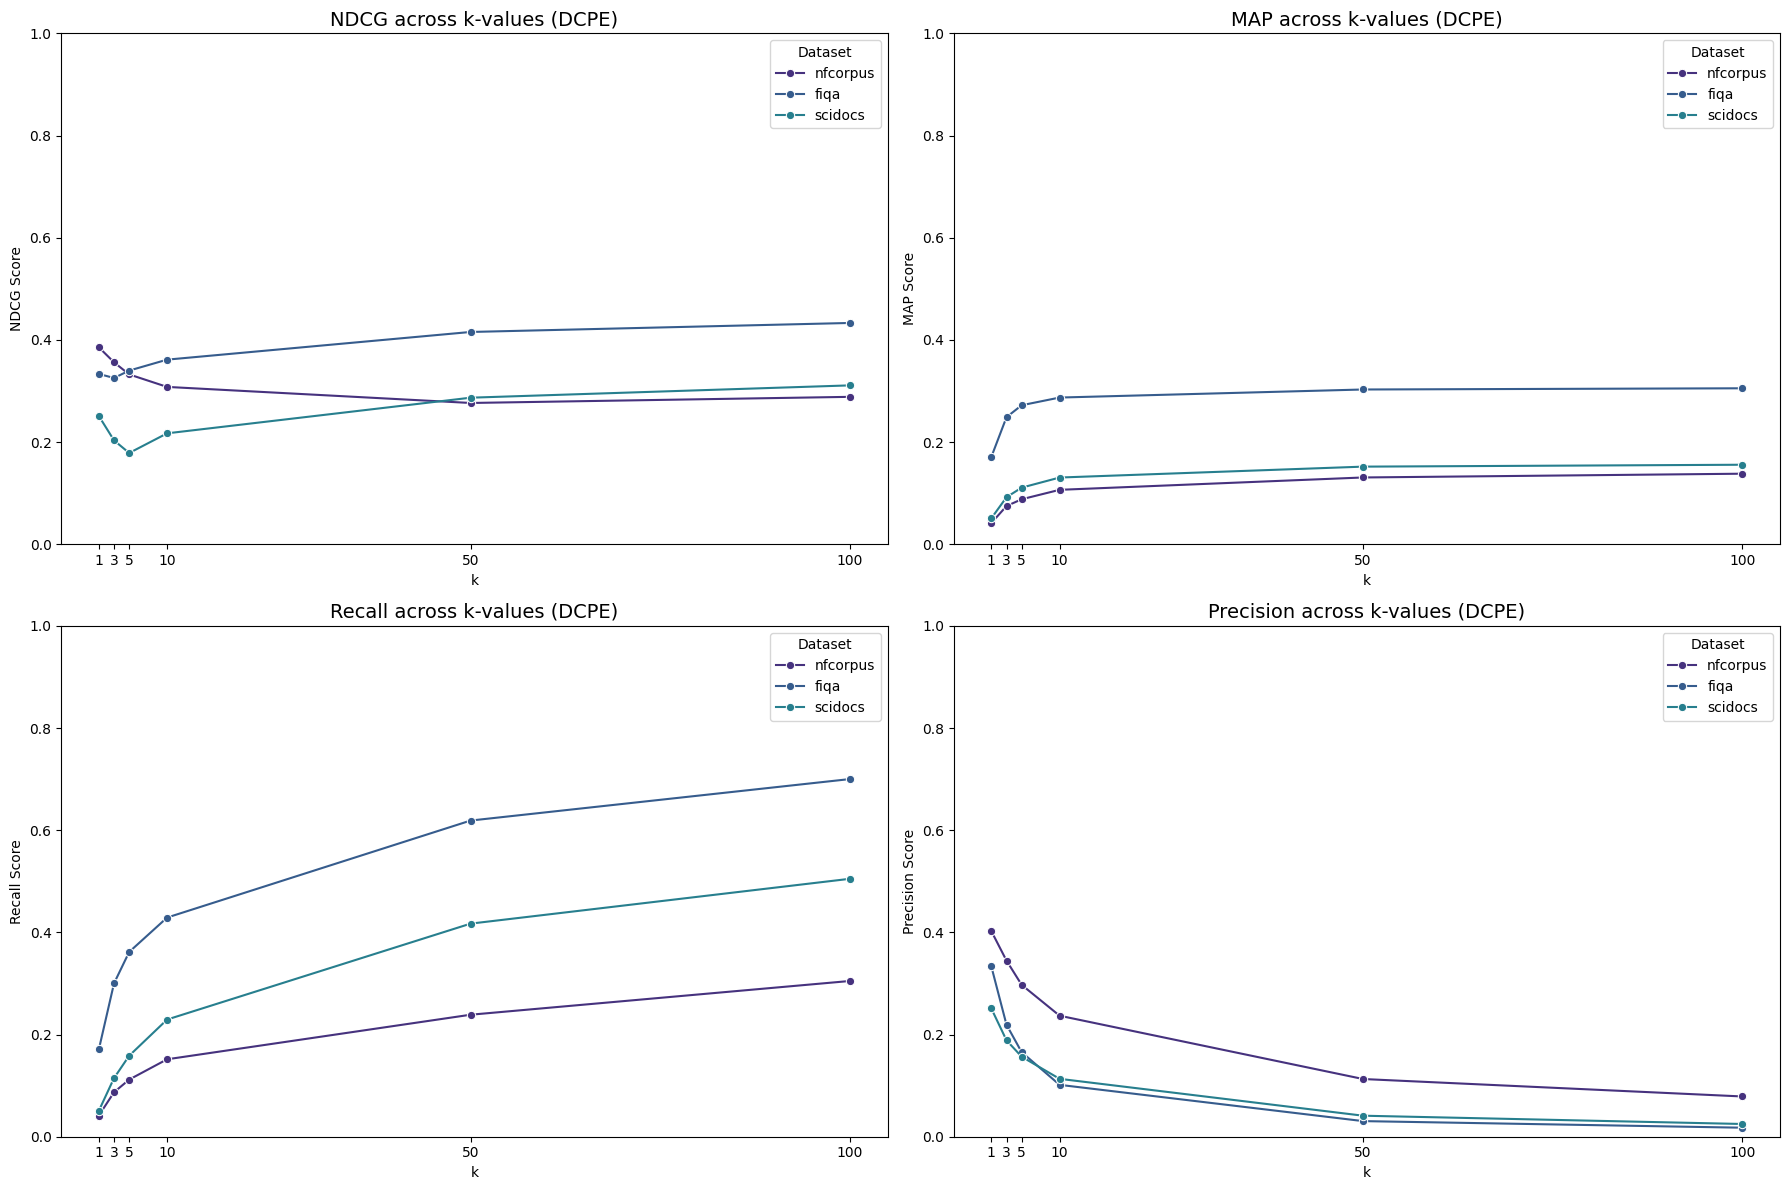

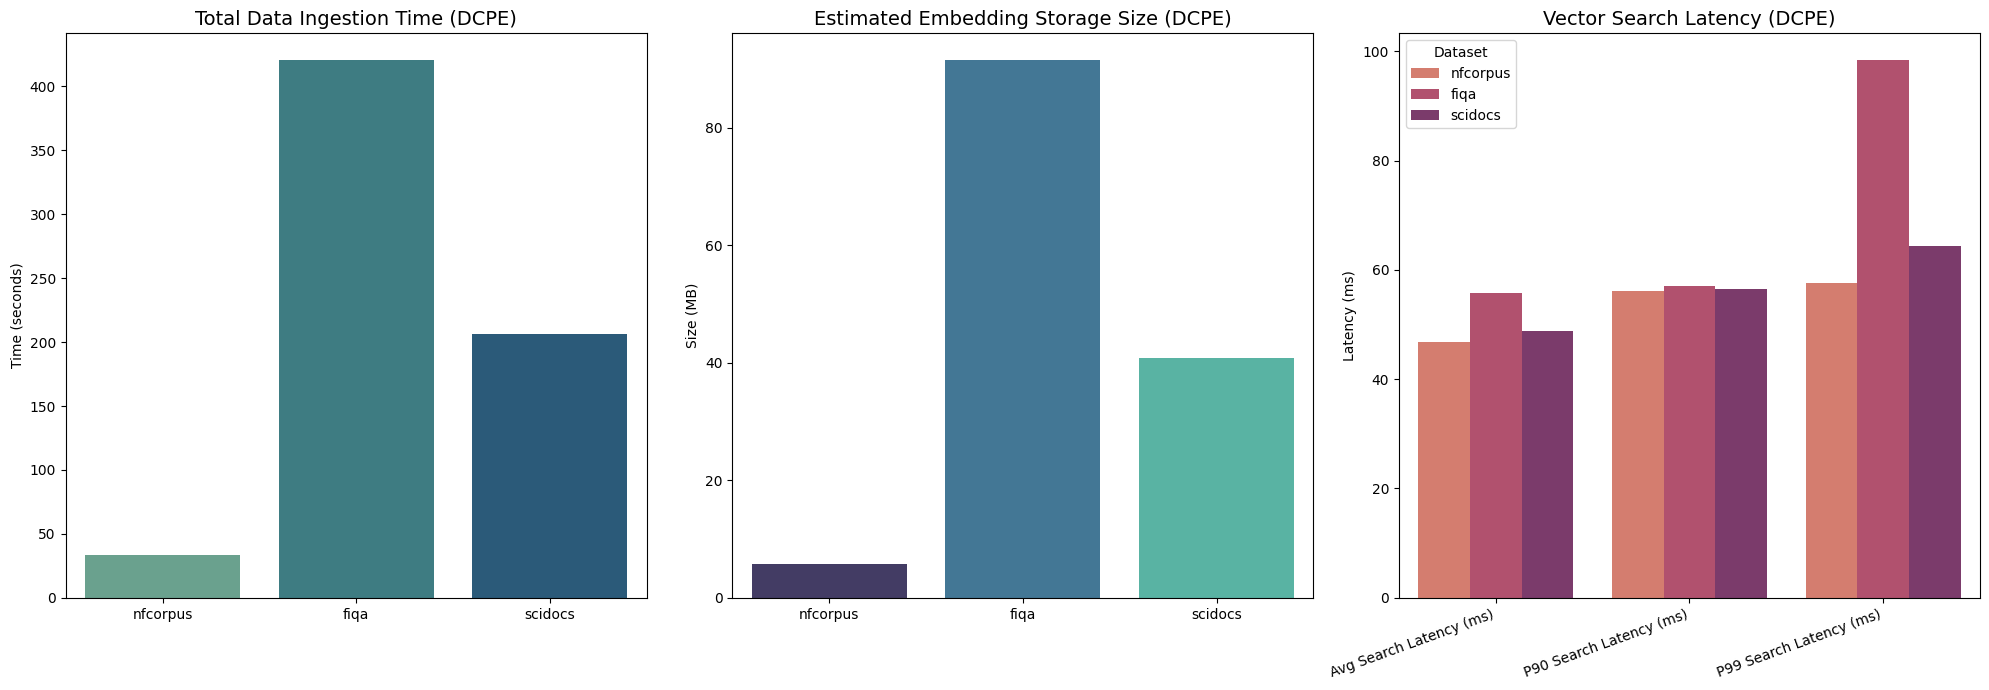

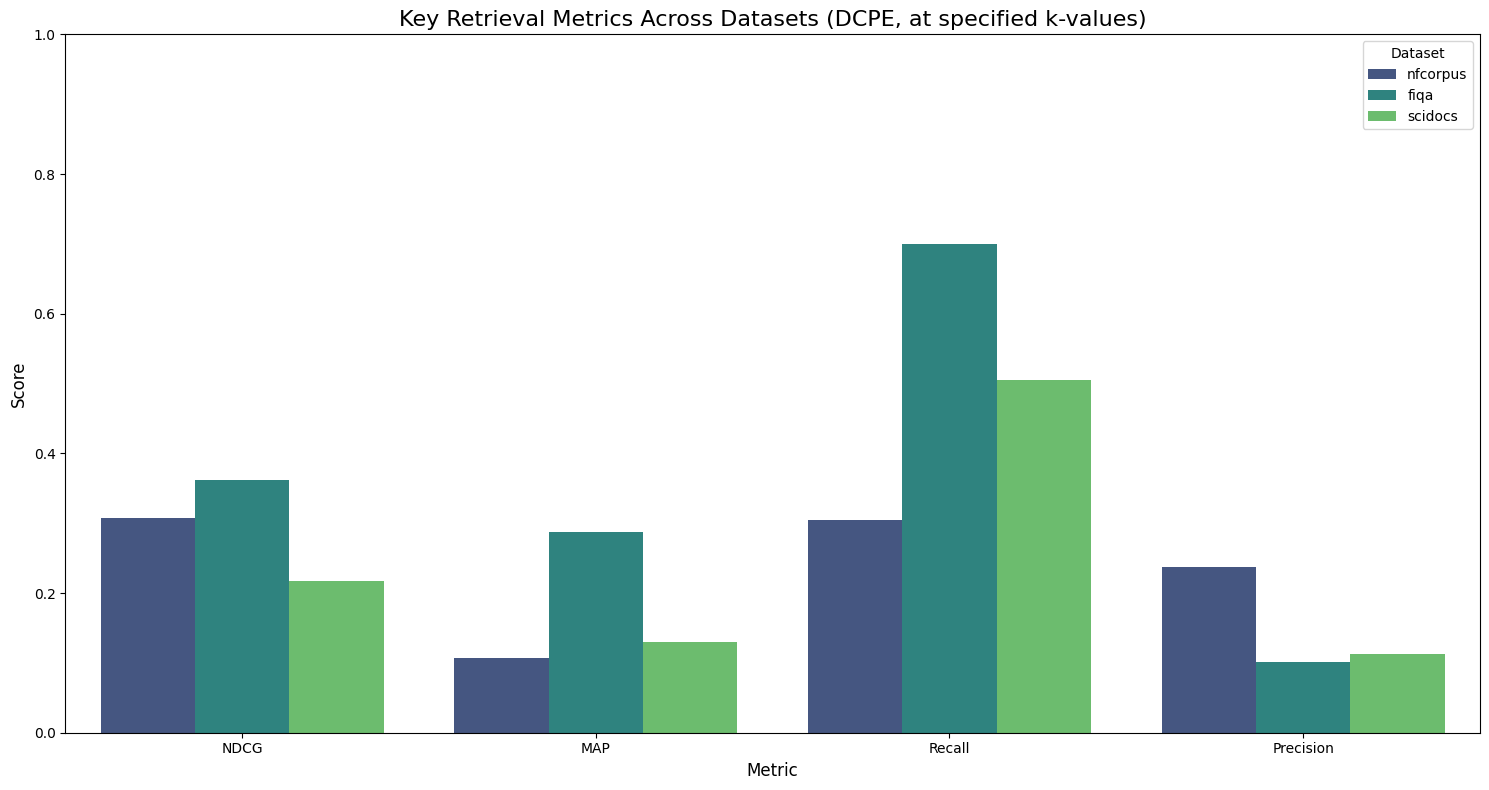

In [45]:
flattened_results = []
for dataset_result in all_evaluation_results:
    row = {"Dataset": dataset_result["Dataset"]}

    for k_value_str, score in dataset_result["NDCG@k"].items():
        row[f"{k_value_str}"] = score

    for k_value_str, score in dataset_result["MAP@k"].items():
        row[f"{k_value_str}"] = score

    for k_value_str, score in dataset_result["Recall@k"].items():
        row[f"{k_value_str}"] = score

    for k_value_str, score in dataset_result["Precision@k"].items():
        row[f"{k_value_str}"] = score

    row["Avg_Search_Latency_ms"] = dataset_result["Avg_Search_Latency_ms"]
    row["P90_Search_Latency_ms"] = dataset_result["P90_Search_Latency_ms"]
    row["P99_Search_Latency_ms"] = dataset_result["P99_Search_Latency_ms"]
    row["Total_Ingestion_Time_s"] = dataset_result["Total_Ingestion_Time_s"]
    row["Estimated_Embedding_Size_MB"] = dataset_result["Estimated_Embedding_Size_MB"]
    row["Num_Documents"] = dataset_result["Num_Documents"]

    flattened_results.append(row)

results_df = pd.DataFrame(flattened_results)

beir_metric_prefixes = ["NDCG@", "MAP@", "Recall@", "P@"]
beir_columns = sorted([col for col in results_df.columns if any(col.startswith(prefix) for prefix in beir_metric_prefixes)])
operational_columns = [
    "Total_Ingestion_Time_s", "Estimated_Embedding_Size_MB",
    "Avg_Search_Latency_ms", "P90_Search_Latency_ms", "P99_Search_Latency_ms",
    "Num_Documents"
]
ordered_columns = ['Dataset'] + beir_columns + operational_columns
results_df = results_df[ordered_columns]

print("\n--- Consolidated BEIR Evaluation Results (DCPE Encrypted) ---")
print(results_df.to_string())

print("\n--- Generating Comprehensive Visualizations (DCPE Encrypted) ---")

# --- BEIR Metrics Visualization (Comprehensive Line Plots) ---
beir_plot_data = []
for dataset_result in all_evaluation_results:
    dataset_name = dataset_result["Dataset"]
    for metric_type, scores_dict in [
        ("NDCG", dataset_result["NDCG@k"]),
        ("MAP", dataset_result["MAP@k"]),
        ("Recall", dataset_result["Recall@k"]),
        ("Precision", dataset_result["Precision@k"])
    ]:
        for k_str, score in scores_dict.items():
            k_val = int(k_str.split('@')[-1])
            beir_plot_data.append({
                "Dataset": dataset_name,
                "Metric Type": metric_type,
                "k": k_val,
                "Score": score
            })
beir_plot_df = pd.DataFrame(beir_plot_data)

if not beir_plot_df.empty:
    plt.figure(figsize=(18, 12))
    sns.set_palette("viridis")

    plt.subplot(2, 2, 1)
    sns.lineplot(x="k", y="Score", hue="Dataset", data=beir_plot_df[beir_plot_df['Metric Type'] == 'NDCG'], marker='o')
    plt.title("NDCG across k-values (DCPE)", fontsize=14)
    plt.xlabel("k", fontsize=10)
    plt.ylabel("NDCG Score", fontsize=10)
    plt.ylim(0, 1.0)
    plt.xticks(k_values)
    plt.legend(title="Dataset", loc='best')

    plt.subplot(2, 2, 2)
    sns.lineplot(x="k", y="Score", hue="Dataset", data=beir_plot_df[beir_plot_df['Metric Type'] == 'MAP'], marker='o')
    plt.title("MAP across k-values (DCPE)", fontsize=14)
    plt.xlabel("k", fontsize=10)
    plt.ylabel("MAP Score", fontsize=10)
    plt.ylim(0, 1.0)
    plt.xticks(k_values)
    plt.legend(title="Dataset", loc='best')

    plt.subplot(2, 2, 3)
    sns.lineplot(x="k", y="Score", hue="Dataset", data=beir_plot_df[beir_plot_df['Metric Type'] == 'Recall'], marker='o')
    plt.title("Recall across k-values (DCPE)", fontsize=14)
    plt.xlabel("k", fontsize=10)
    plt.ylabel("Recall Score", fontsize=10)
    plt.ylim(0, 1.0)
    plt.xticks(k_values)
    plt.legend(title="Dataset", loc='best')

    plt.subplot(2, 2, 4)
    sns.lineplot(x="k", y="Score", hue="Dataset", data=beir_plot_df[beir_plot_df['Metric Type'] == 'Precision'], marker='o')
    plt.title("Precision across k-values (DCPE)", fontsize=14)
    plt.xlabel("k", fontsize=10)
    plt.ylabel("Precision Score", fontsize=10)
    plt.ylim(0, 1.0)
    plt.xticks(k_values)
    plt.legend(title="Dataset", loc='best')

    plt.tight_layout()
    plt.show()
else:
    print("No BEIR evaluation data available for plotting.")

# --- Operational Metrics Visualization (Bar Plots) ---
operational_plot_data = []
for dataset_result in all_evaluation_results:
    operational_plot_data.append({
        "Dataset": dataset_result["Dataset"],
        "Total Ingestion Time (s)": dataset_result["Total_Ingestion_Time_s"],
        "Estimated Embedding Size (MB)": dataset_result["Estimated_Embedding_Size_MB"],
        "Avg Search Latency (ms)": dataset_result["Avg_Search_Latency_ms"],
        "P90 Search Latency (ms)": dataset_result["P90_Search_Latency_ms"],
        "P99 Search Latency (ms)": dataset_result["P99_Search_Latency_ms"]
    })
operational_df = pd.DataFrame(operational_plot_data)

if not operational_df.empty:
    plt.figure(figsize=(20, 7))

    plt.subplot(1, 3, 1)
    sns.barplot(x="Dataset", y="Total Ingestion Time (s)", data=operational_df, palette="crest")
    plt.title("Total Data Ingestion Time (DCPE)", fontsize=14)
    plt.ylabel("Time (seconds)", fontsize=10)
    plt.xlabel("")
    plt.tight_layout()

    plt.subplot(1, 3, 2)
    sns.barplot(x="Dataset", y="Estimated Embedding Size (MB)", data=operational_df, palette="mako")
    plt.title("Estimated Embedding Storage Size (DCPE)", fontsize=14)
    plt.ylabel("Size (MB)", fontsize=10)
    plt.xlabel("")
    plt.tight_layout()

    plt.subplot(1, 3, 3)
    latency_melted_df = operational_df.melt(id_vars=['Dataset'],
                                            value_vars=["Avg Search Latency (ms)", "P90 Search Latency (ms)", "P99 Search Latency (ms)"],
                                            var_name="Latency Type", value_name="Latency (ms)")
    sns.barplot(x="Latency Type", y="Latency (ms)", hue="Dataset", data=latency_melted_df, palette="flare")
    plt.title("Vector Search Latency (DCPE)", fontsize=14)
    plt.ylabel("Latency (ms)", fontsize=10)
    plt.xlabel("")
    plt.xticks(rotation=20, ha='right')
    plt.legend(title="Dataset", loc='best')
    plt.tight_layout()

    plt.tight_layout()
    plt.show()
else:
    print("No operational metrics data available for plotting.")

# --- Summary Metrics Visualization (Bar Plot for key k-values) ---
# This is the "missing" plot from your previous description, now correctly included.
metrics_to_plot_summary = {
    "NDCG": "NDCG@10",
    "MAP": "MAP@10",
    "Recall": "Recall@100",
    "Precision": "P@10"
}

summary_plot_data = []
for index, row in results_df.iterrows():
    dataset = row['Dataset']
    for metric_name, col_name in metrics_to_plot_summary.items():
        if col_name in row:
            summary_plot_data.append({
                "Dataset": dataset,
                "Metric": metric_name,
                "Value": row[col_name],
                "K_Value": col_name.split('@')[-1]
            })

summary_plot_df = pd.DataFrame(summary_plot_data)

if not summary_plot_df.empty:
    plt.figure(figsize=(15, 8))
    sns.barplot(x="Metric", y="Value", hue="Dataset", data=summary_plot_df, palette="viridis")
    plt.title("Key Retrieval Metrics Across Datasets (DCPE, at specified k-values)", fontsize=16)
    plt.xlabel("Metric", fontsize=12)
    plt.ylabel("Score", fontsize=12)
    plt.ylim(0, 1.0)
    plt.legend(title="Dataset")
    plt.tight_layout()
    plt.show()
else:
    print("No summary plot data available.")